# Assignment 2: Generating "Human-Like Melody from a Given Corpus

## Part 1: Preprocessing - Parsing the dataset

Goal: Parse the abc music files to only get the elements related to the rhythm and pitch. We will use music21 to obtain, from each piece's abc file, a list of bars with each bar containing the beat onset on which a note appears, and the pitch of each corresponding note in midi number. Then, we will create a Dataframe of all the pieces encoded in list form, which we can split to use as a training set and a test set.

In [1]:
# !pip install music21
# !pip install textract
# !pip install networkx

import pandas as pd
import numpy as np
import ast
import music21
import os
import textract
import pathlib
from collections import defaultdict
from collections import Counter
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
# Function that, from an abc file, gets the beat distribution of every bar of the piece
# Returns an array (piece) of arrays (bars)
def extractBeatArray(path):

    # getting the parsable score
    sample = music21.converter.parse(path)
    part = sample.parts[0]
    notes = part.recurse().notes
    length_in_bars = int(sample.duration.quarterLength/sample.getTimeSignatures()[0].numerator) 
    # should be numerator*(denominator/4), but here denominator is already 4 since all pieces are in 3/4
    
    bars = []

    # iteratively adding every beat of every bar. Each bar is a list and the piece is a list of bars i.e. a list of lists
    for i in range(0, length_in_bars):
        if part.measure(i) is not None:
            notes = part.measure(i).notes
            beats = []
            for n in notes:
                beats.append(n.beat)
                    
        bars.append(beats)
        i += 1

    return bars

# Function that, from an abc file, gets the pitch distribution of every bar of the piece
# Returns an array (piece) of arrays (bars)
def extractPitchArray(path):

    # getting the parsable score
    sample = music21.converter.parse(path)
    part = sample.parts[0]
    notes = part.recurse().notes
    length_in_bars = int(sample.duration.quarterLength/sample.getTimeSignatures()[0].numerator) 
    # should be numerator*(denominator/4), but here denominator is already 4 since all pieces are in 3/4
    
    bars = []

    # iteratively adding every beat of every bar. Each bar is a list and the piece is a list of bars i.e. a list of lists
    for i in range(0, length_in_bars):
        if part.measure(i) is not None:
            notes = part.measure(i).notes
            beats = []
            for n in notes:
                beats.append(n.pitch.midi) # should we also use pitchClass (no octave) or is the octave important
                    
        bars.append(beats)
        
        i += 1

    return bars

In [10]:
# Parsing the dataset with the above function

data = pd.DataFrame(columns=['piece', 'beats', 'pitches'])

path = "./abc/_1814_698087.abc"

directory = './abc'

pieces = 0 # check every piece in the directory (599) is encoded

for name in os.listdir(directory):
    pieces += 1
    path = directory + '/' + name 
    bars_beats = []
    bars_pitches = []
    try:
        bars_beats = extractBeatArray(path)
    except:
        bars_beats = []
    try:
        bars_pitches = extractPitchArray(path)
    except:
        bars_pitches = []

    if ((bars_beats != []) & (bars_pitches != [])): # not adding unparsed pieces to dataframe
        data.loc[len(data)] = [path, bars_beats, bars_pitches]


print(f"{pieces} pieces were analysed.")    

print(f"{len(data)} pieces were correctly parsed.")

599 pieces were analysed.
484 pieces were correctly parsed.


In [11]:
# Function that maps the beat distribution of a bar to a series of numbers between 1 and 12 (position of each sixteenth-note in the bar)
def map_beats(notes):
    notes_mapped = []
    for bar in notes:
        bar_mapped = []
        for x in bar:
            bar_mapped.append(int(4*(x-1)+1))
        notes_mapped.append(bar_mapped)
    return notes_mapped

In [12]:
# Function that maps a series of numbers between 1 and 12 (position of each sixteenth-note in the bar) to a music21 beat distribution
def map_beats_reverse(notes):
    notes_mapped = []
    for bar in notes:
        bar_mapped = []
        for y in bar:
            bar_mapped.append((y+3)/4)
        notes_mapped.append(bar_mapped)
    return notes_mapped

In [18]:
# Testing the function
example_notes = data[data['piece'] == './abc/1b651a94a8f8680da3cef1e60705194d.abc']['beats'].tolist()[0]
# when we retrieve a specific piece and convert to list it wraps the piece's array in another array for some reason, hence the [0]
# but when doing iterrows we don't have that problem
print(example_notes)
map_12 = map_beats(example_notes)
print(map_12)
print(map_beats_reverse(map_12))

[[1.0, 1.5, 2.0, 2.25, 2.5, 2.75, 3.0, 3.5], [1.0, 1.5, 2.0, 2.25, 2.5, 2.75, 3.0, 3.5], [1.0, 1.5, 1.75, 2.0, 2.5, 2.75, 3.0, 3.5]]
[[1, 3, 5, 6, 7, 8, 9, 11], [1, 3, 5, 6, 7, 8, 9, 11], [1, 3, 4, 5, 7, 8, 9, 11]]
[[1.0, 1.5, 2.0, 2.25, 2.5, 2.75, 3.0, 3.5], [1.0, 1.5, 2.0, 2.25, 2.5, 2.75, 3.0, 3.5], [1.0, 1.5, 1.75, 2.0, 2.5, 2.75, 3.0, 3.5]]


In [19]:
# Using the mapping function on every piece
data_mapped = data.copy()

for _, d in data_mapped.iterrows():
    d['beats'] = map_beats(d['beats'])

print("Done")

data_mapped.head() # our dataframe for the model!

Done


,piece,beats,pitches
0,./abc/1b651a94a8f8680da3cef1e60705194d.abc,"[[1, 3, 5, 6, 7, 8, 9, 11], [1, 3, 5, 6, 7, 8,...","[[69, 76, 81, 83, 81, 79, 77, 74], [74, 76, 79..."
1,./abc/3679c385a618c89f00d159f418022b39.abc,"[[1, 3, 4, 5, 7, 8, 9, 11], [1, 4, 5, 6, 7, 8,...","[[76, 76, 81, 76, 76, 77, 76, 74], [72, 71, 69..."
2,./abc/60ae81952628613e03d563b0dae8bbc2.abc,"[[1, 4, 5, 7, 9, 10, 11, 12], [1, 3, 5, 9, 11]]","[[62, 67, 71, 74, 72, 71, 72, 69], [67, 71, 62..."
3,./abc/6a7d307d1f0712090e4043a6b4637efa.abc,"[[1, 5, 9], [1, 1, 3, 4, 5, 7, 9, 11], [1, 4, ...","[[64, 69, 71], [71, 72, 71, 72, 74, 72, 71, 69..."
4,./abc/8c6965e3c831e8cb769e578423c12d1e.abc,"[[1, 5, 7, 8, 9], [1, 3, 4, 5, 6, 7, 8, 9, 10,...","[[69, 67, 66, 67, 69], [69, 71, 73, 74, 73, 74..."


In [20]:
# Splitting the data into train and test
from sklearn.model_selection import train_test_split
# set random seed for reproducibility
x_train, x_test = train_test_split(data_mapped, random_state=42) # split 75% train 25% test

print(len(x_train))
print(len(x_test))

363
121


In [21]:
# Writing train and test to csv
x_train.to_csv("train.csv", index=False)
x_test.to_csv("test.csv", index=False)

## Part 2: The Random Model

**Goal:** generate random 8-bar melodies (rhythm + pitch). The only constraints are the following: 
- the minimal note duration is a sixteenth note.
- all pitches are between C4 and C5

In [24]:
import random

random.seed(1113)

In [25]:
# function to fill a bar with random notes
def random_bar():
    # first = True
    first = False
    # first decide how many notes are in the bar
    # (the tempo is always 3/4)
    bar = []
    for i in range(11):
        # decide if a note is played
        if first:
            bar.append(1.0)
            first = False
        elif random.random() < 0.5:
            # if yes, decide which note
            bar.append((i/4)+1)
        # check that the bar is not empty
    if len(bar) == 0:
        bar = random_bar()
    return bar

# create a scale with all the notes from C4 to C5
sc = music21.scale.MajorScale('C4')
# get all the pitches from the scale
pitch_collection = sc.getPitches('C4', 'C5')
print(f"pitch_collection contains {len(pitch_collection)} pitches.")
print(pitch_collection)

# create list with pitches for the bar
def create_pitches(size, pitch_collection= pitch_collection):
    list_p = []
    for i in range(size):
        # append a random pitch from the scale
        list_p.append(random.choice(pitch_collection))
    return list_p

# create random song
def create_random_song():
    # make a list with 8 lists inside
    random_song = [[] for j in range(8)]
    random_pitches = [[] for j in range(8)]
    # for each list in random_song fill it with random notes
    for i in range(8):
        random_song[i] = random_bar()
        random_pitches[i] = create_pitches(len(random_song[i]))
    return random_song, random_pitches

pitch_collection contains 8 pitches.
[<music21.pitch.Pitch C4>, <music21.pitch.Pitch D4>, <music21.pitch.Pitch E4>, <music21.pitch.Pitch F4>, <music21.pitch.Pitch G4>, <music21.pitch.Pitch A4>, <music21.pitch.Pitch B4>, <music21.pitch.Pitch C5>]


In [26]:
# example
random_song, random_pitches = create_random_song()
print('random song: ')
print(random_song)
print('random pitches: ')
print(random_pitches)

random song: 
[[1.0, 1.25, 1.75, 2.0, 2.5, 3.0], [1.25, 1.75, 2.0, 2.5, 2.75, 3.25, 3.5], [1.0, 2.25, 2.5, 2.75, 3.0, 3.5], [1.75, 3.0, 3.25], [1.75, 2.25, 2.75, 3.0, 3.25], [1.75, 2.0, 2.25, 2.75, 3.25, 3.5], [1.0, 1.5, 1.75, 2.0, 2.25, 2.5, 3.0, 3.5], [2.0, 2.5, 3.0, 3.25]]
random pitches: 
[[<music21.pitch.Pitch D4>, <music21.pitch.Pitch B4>, <music21.pitch.Pitch C4>, <music21.pitch.Pitch D4>, <music21.pitch.Pitch D4>, <music21.pitch.Pitch D4>], [<music21.pitch.Pitch D4>, <music21.pitch.Pitch F4>, <music21.pitch.Pitch C5>, <music21.pitch.Pitch F4>, <music21.pitch.Pitch A4>, <music21.pitch.Pitch A4>, <music21.pitch.Pitch B4>], [<music21.pitch.Pitch D4>, <music21.pitch.Pitch B4>, <music21.pitch.Pitch G4>, <music21.pitch.Pitch C4>, <music21.pitch.Pitch E4>, <music21.pitch.Pitch C5>], [<music21.pitch.Pitch C5>, <music21.pitch.Pitch F4>, <music21.pitch.Pitch E4>], [<music21.pitch.Pitch C5>, <music21.pitch.Pitch F4>, <music21.pitch.Pitch A4>, <music21.pitch.Pitch D4>, <music21.pitch.Pitch

In [27]:
# function to convert from beats into durations
def convert_to_duration(random_song_list):
    last = 3.0
    # read the list backwards
    random_song_list.reverse()
    # create a list with the duration of each note
    duration_list = []
    for bar in random_song_list:
        # reverse the inner list
        bar.reverse()
        for note in bar:
            duration_list.append(last - note)
            last = note
        last += 3.0
    # reverse the list again
    duration_list.reverse()
    # return original order to original song aswell
    random_song_list.reverse()
    for bar in random_song_list:
        bar.reverse()
    return duration_list

In [31]:
# example
duration_list = convert_to_duration(random_song)
print('Duration list example: ')
print(duration_list)

Duration list example: 
[0.25, 0.5, 0.25, 0.5, 0.5, 1.25, 0.5, 0.25, 0.5, 0.25, 0.5, 0.25, 0.5, 1.25, 0.25, 0.25, 0.25, 0.5, 1.25, 1.25, 0.25, 1.5, 0.5, 0.5, 0.25, 0.25, 1.5, 0.25, 0.25, 0.5, 0.5, 0.25, 0.5, 0.5, 0.25, 0.25, 0.25, 0.25, 0.5, 0.5, 1.5, 0.5, 0.5, 0.25, -0.25]


In [35]:
# Function that creates a list of notes from pitches
def elongate_pitch_list(pitch_list):
    new_list = []
    for bar in pitch_list:
        for note in bar:
            new_list.append(note)
    return new_list

# translate the music21 pitches to midi numbers
def translate_pitches(pitches):
    midi_pitches = []
    for bar in pitches:
        bar_midi = []
        for pitch in bar:
            bar_midi.append(pitch.midi)
        midi_pitches.append(bar_midi)
    return midi_pitches

In [36]:
def convert_to_stream(duration_list, pitch_list):
    pitch_list = elongate_pitch_list(pitch_list)
    # create an empty stream
    stream = music21.stream.Stream()
    # define the tempo as 3/4
    stream.append(music21.meter.TimeSignature('3/4'))
    # create note
    # assign the pitch of the random_pitches list
    # assign duration (quarter)
    # append the note into empty stream
    count = 0
    for duration in duration_list:
        note = music21.note.Note(pitch=pitch_list[count], quarterLength=duration)
        stream.append(note)
        count += 1
    return stream

In [37]:
# example
stream = convert_to_stream(duration_list, random_pitches)

# print with map_beats convertion (map_beats function from Part 1) and without
print('Random sequence represented by integers:\n',map_beats(random_song))
print('Random sequence represented by beats:\n',map_beats_reverse(map_beats(random_song)))

# play the stream
stream.show('midi')

Random sequence represented by integers:
 [[1, 2, 4, 5, 7, 9], [2, 4, 5, 7, 8, 10, 11], [1, 6, 7, 8, 9, 11], [4, 9, 10], [4, 6, 8, 9, 10], [4, 5, 6, 8, 10, 11], [1, 3, 4, 5, 6, 7, 9, 11], [5, 7, 9, 10]]
Random sequence represented by beats:
 [[1.0, 1.25, 1.75, 2.0, 2.5, 3.0], [1.25, 1.75, 2.0, 2.5, 2.75, 3.25, 3.5], [1.0, 2.25, 2.5, 2.75, 3.0, 3.5], [1.75, 3.0, 3.25], [1.75, 2.25, 2.75, 3.0, 3.25], [1.75, 2.0, 2.25, 2.75, 3.25, 3.5], [1.0, 1.5, 1.75, 2.0, 2.25, 2.5, 3.0, 3.5], [2.0, 2.5, 3.0, 3.25]]


In [38]:
# print with translate_pitches conversion
print('Random song with pitches as midi numbers: ')
print(translate_pitches(random_pitches))

Random song with pitches as midi numbers: 
[[62, 71, 60, 62, 62, 62], [62, 65, 72, 65, 69, 69, 71], [62, 71, 67, 60, 64, 72], [72, 65, 64], [72, 65, 69, 62, 64], [65, 60, 67, 65, 67, 67], [71, 60, 72, 62, 65, 64, 64, 69], [62, 72, 69, 62]]


In [43]:
# produce a dataframe size 500 samples and save it as csv

# os.mkdir("./random_rhythms") # this was run once, no need to run it again

# produce a dataframe size 500 samples and save it as csv
def produce_dataframe():
    df = pd.DataFrame(columns=['id', 'beats', 'pitches', 'tuple_beat_and_pitch', 'midi'])
    for i in range(500):
        random_song, random_pitches = create_random_song()
        # write stream to midi file
        stream = convert_to_stream(convert_to_duration(random_song),random_pitches)
        # save midi in the random_midis folder
        file_midi = f'random_midis/random_song_{i}.mid'
        stream.write('midi', file_midi)
        notes = map_beats(random_song)
        pitches = translate_pitches(random_pitches)
        tuples_note_pitch = []
        for i in range(len(notes)):
            for j in range(len(notes[i])):
                tuples_note_pitch.append((notes[i][j], pitches[i][j]))
        df.loc[len(df)] = [i, notes, pitches, tuples_note_pitch, file_midi]
    df.to_csv('random_songs.csv', index=False)
    return df

# our data
df = produce_dataframe()
print(f"{len(df)} random songs generated.")

# save
df.to_csv('random_songs.csv', index=False)

# display
df.head()

500 random songs generated.


,id,beats,pitches,tuple_beat_and_pitch,midi
0,7,"[[1, 2, 3, 4, 5, 9, 11], [2, 3, 6, 7, 10], [1,...","[[65, 67, 72, 65, 60, 62, 64], [62, 72, 69, 64...","[(1, 65), (2, 67), (3, 72), (4, 65), (5, 60), ...",random_midis/random_song_0.mid
1,7,"[[1, 5, 7, 8, 9, 11], [1, 3, 4, 5, 7, 8, 9, 10...","[[69, 65, 62, 71, 62, 69], [72, 64, 71, 64, 69...","[(1, 69), (5, 65), (7, 62), (8, 71), (9, 62), ...",random_midis/random_song_1.mid
2,7,"[[1, 2, 3, 4, 5], [2, 3, 5, 8, 9, 10], [1, 5, ...","[[62, 69, 71, 64, 69], [69, 65, 71, 60, 72, 67...","[(1, 62), (2, 69), (3, 71), (4, 64), (5, 69), ...",random_midis/random_song_2.mid
3,7,"[[3, 8], [3, 4, 7, 8, 10, 11], [1, 2, 6, 7, 8,...","[[72, 72], [71, 69, 67, 67, 64, 64], [62, 67, ...","[(3, 72), (8, 72), (3, 71), (4, 69), (7, 67), ...",random_midis/random_song_3.mid
4,7,"[[3, 5, 6, 8, 10], [1, 5, 6, 10, 11], [1, 2, 4...","[[69, 69, 64, 71, 60], [72, 65, 71, 60, 62], [...","[(3, 69), (5, 69), (6, 64), (8, 71), (10, 60),...",random_midis/random_song_4.mid


## Part 3: The Generation Model

**Goal:** generate "human-like" 8-bar melodies in the style of Slängpolska. We will use a bigram-based Markov chain model, trained on 75% of the dataset as per the train-test split done in part 1.

In [46]:
np.random.seed(401)

markov_data = pd.read_csv('train.csv')
markov_data.head()

,piece,beats,pitches
0,./abc/_Polonäs_sexdregasamlingen_del_2_nr_43_9...,"[[1, 5, 7, 9, 11], [1, 3, 5, 7, 9, 11], [1, 5,...","[[74, 69, 67, 66, 64], [62, 79, 78, 76, 78, 76..."
1,./abc/Pollonesse_ur_Andreas_Dahlgrens_notbok_n...,"[[1, 3, 5, 7, 9, 11], [1, 2, 3, 4, 5], [1, 1, ...","[[67, 79, 79, 78, 79, 76], [76, 78, 79, 76, 74..."
2,./abc/Polska_efter_Anders_Gustaf_Andersson_0ac...,"[[1, 3, 5, 7, 9, 11], [1, 3, 4, 5, 9], [1, 1, ...","[[81, 76, 77, 76, 77, 79], [81, 77, 81, 79, 76..."
3,./abc/Polonäs_9c99ae.abc,"[[1, 2, 3, 4, 5, 7, 9, 10, 11, 12], [1, 4, 5, ...","[[74, 72, 70, 69, 67, 62, 60, 58, 57, 55], [67..."
4,./abc/_Polonäs_sexdregasamlingen_del_2_nr_76_5...,"[[1, 3, 4, 5, 7, 9], [1, 3, 4, 5, 7, 8, 9], [1...","[[79, 78, 76, 74, 72, 71], [67, 67, 71, 69, 69..."


In [49]:
import ast
# change the note column to list
data['beats'] = data['beats'].apply(ast.literal_eval)
data['pitches'] = data['pitches'].apply(ast.literal_eval)
data['beat_pitch'] = data['beat_pitch'].apply(ast.literal_eval)

ValueError: malformed node or string: [[1.0, 1.5, 2.0, 2.25, 2.5, 2.75, 3.0, 3.5], [1.0, 1.5, 2.0, 2.25, 2.5, 2.75, 3.0, 3.5], [1.0, 1.5, 1.75, 2.0, 2.5, 2.75, 3.0, 3.5]]

In [82]:
# get the bigram of the music data
bigram = []
bigram_freq = defaultdict(int)

# get the bigram of each song
for i in range(len(markov_data)):
    for bar in markov_data.loc[i,'notes']:
        bigram.extend(zip(bar, bar[1:]))
    
# print(bigram)

# get the frequency of every bigram
bigram_freq = dict(Counter(bigram))
print(len(bigram_freq))

45


In [83]:
# remove the identical bigram or bigram with wrong direction
wrong_bigrams = []
for key in bigram_freq:
    if key[0] >= key[1] or key[1]>12:
        wrong_bigrams.append(key)
for key in wrong_bigrams:
    del bigram_freq[key]
print(len(bigram_freq))
print(bigram_freq)

33
{(1, 2): 2278, (2, 3): 2275, (3, 4): 4056, (4, 5): 4434, (5, 6): 1893, (6, 7): 1891, (7, 8): 3100, (8, 9): 3203, (9, 11): 2997, (11, 12): 1926, (5, 7): 3310, (7, 9): 2111, (9, 12): 111, (1, 4): 383, (1, 3): 3539, (3, 5): 1753, (5, 9): 1086, (9, 10): 1288, (10, 11): 1287, (1, 5): 587, (5, 8): 106, (5, 11): 47, (3, 8): 1, (10, 12): 1, (1, 7): 14, (1, 9): 12, (4, 6): 2, (6, 8): 1, (8, 10): 1, (4, 7): 1, (3, 7): 3, (7, 11): 2, (6, 9): 1}


In [84]:
# create the bigram matrix
bigram_counts = np.zeros((12, 12))

# Fill the bigram_counts matrix with the counts from bigram_freq
for (w1, w2), count in bigram_freq.items():
    bigram_counts[w1 - 1, w2 - 1] = count

# Normalize each row to create the transition probability matrix
row_sums = bigram_counts.sum(axis=1, keepdims=True)
bigram_prob = bigram_counts / row_sums

C:\Users\marga\AppData\Local\Temp\ipykernel_17620\3085129566.py:10: RuntimeWarning: invalid value encountered in divide
  bigram_prob = bigram_counts / row_sums


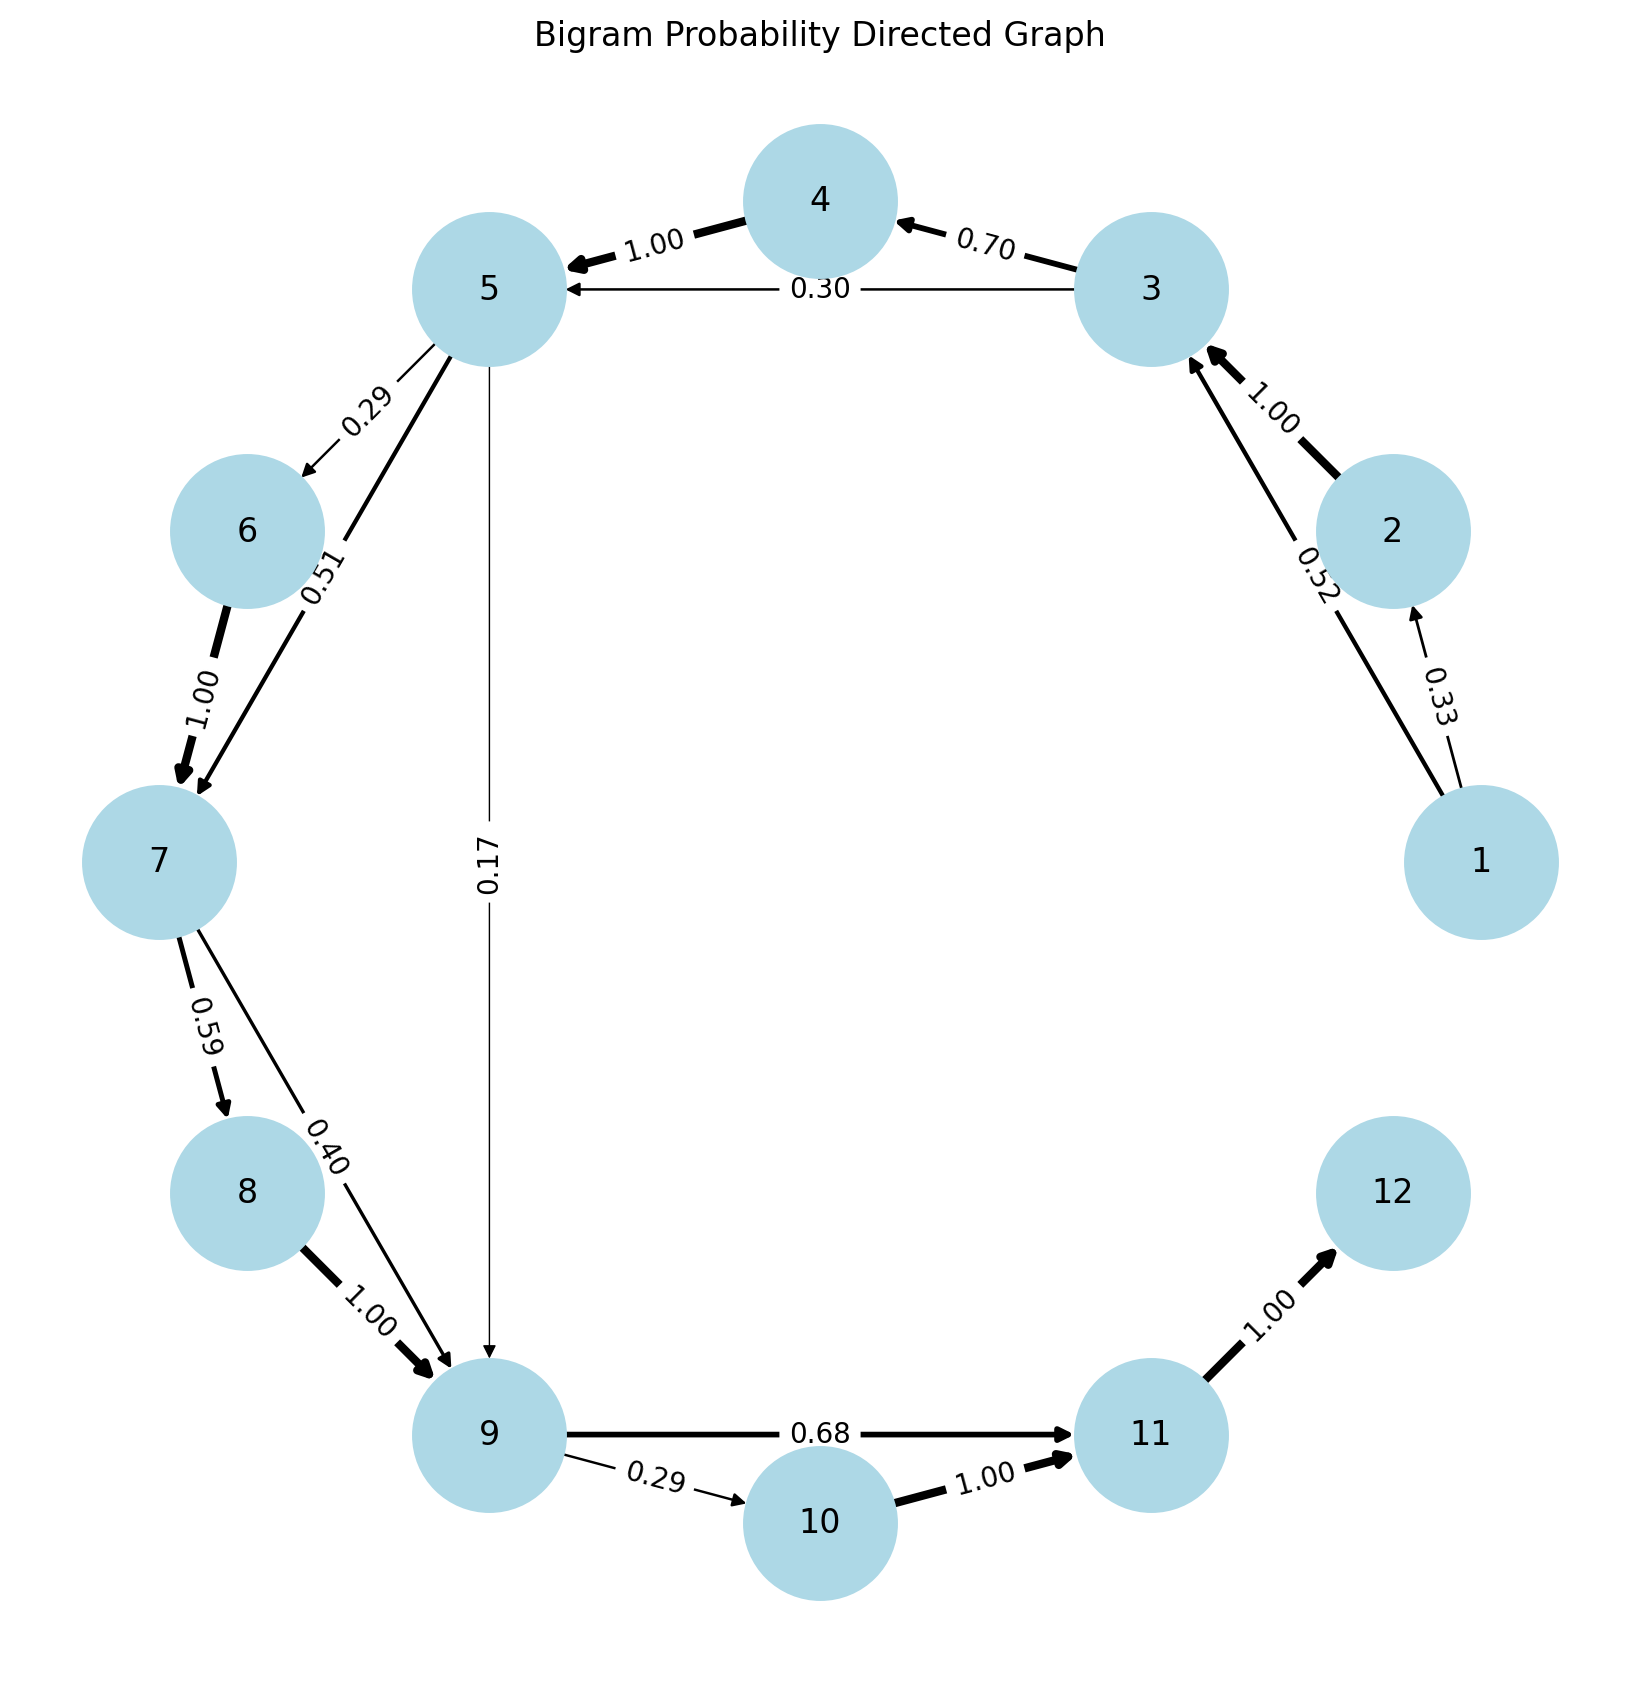

In [85]:
# use networkx to visualize the bigram matrix
note_labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']

# Create a directed graph from the bigram probabilities
G = nx.DiGraph()
for i, row in enumerate(bigram_prob):
    for j, prob in enumerate(row):
        if prob > 0.1:
            G.add_edge(note_labels[i], note_labels[j], weight=prob)

# Visualize the directed graph
plt.figure(figsize=(8,8))

# Create a circular layout with the correct order
pos = {note_labels[i]: (np.cos(2 * np.pi * i / 12), np.sin(2 * np.pi * i / 12)) for i in range(12)}

# Calculate edge widths based on their weights
edge_weights = nx.get_edge_attributes(G, 'weight')
edge_widths = [d * 3 for d in edge_weights.values()]

# Draw the graph with the calculated edge widths and custom positions
nx.draw(G, pos, node_color='lightblue', with_labels=True, node_size=3000, width=edge_widths)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f"{d:.2f}" for (u, v), d in labels.items()})
plt.title('Bigram Probability Directed Graph')
plt.savefig('bigram_probability_directed_graph.png', dpi=300, bbox_inches='tight')
plt.show()

In [86]:
# the generation model

# use the current position to predict the next position
def predict_next_state(bigram_freq, current_state):
    """
    predict the next state based on the bigram frequency
    """
    # get the possible next states
    possible_next_states = [k[1] for k, v in bigram_freq.items() if k[0] == current_state]
    # get the frequency of each possible next state
    freq = [v for k, v in bigram_freq.items() if k[0] == current_state]
    # normalize the frequency
    freq = np.array(freq) / np.sum(freq)
    # predict the next state
    next_state = np.random.choice(possible_next_states, p=freq)
    return next_state

# get the cosine similarity between two bars
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    return dot_product / (norm1 * norm2)

# change the position list to a vector of length 12
def seq_to_vec(seq):
    return [1 if i+1 in seq else 0 for i in range(12)]

# given the start position, generate a bar
def generate_a_bar(bigram_freq, start_state):
    """
    generate a bar based on the bigram frequency
    """
    bar = [start_state]
    while True:
        next_state = predict_next_state(bigram_freq, bar[-1])
        bar.append(next_state)
        # stop when the next state is 12 or the bar is longer than 4 and the next state is larger than 9 at the probability of 0.6
        if next_state == 12 or (len(bar) >= 4 and next_state >= 9 and np.random.random() > 0.6):
            break
    return bar

# generate a sequence of bars
def generate_sequence(bigram_freq, start_state, num_bars, similarity_threshold=0.5):
    """
    generate a sequence based on the bigram frequency
    """
    sequence = [generate_a_bar(bigram_freq, start_state)]
    while len(sequence) < num_bars:
        bar = generate_a_bar(bigram_freq, start_state)
        # compare the similarity between the last bar in the sequence and the new bar
        vec1 = seq_to_vec(sequence[-1])
        vec2 = seq_to_vec(bar)
        similarity = cosine_similarity(vec1, vec2)

        if similarity >= similarity_threshold:
            sequence.append(bar)

    return sequence

In [87]:
def convert_to_duration_no_reverse(random_song_list):
    last = 3.0
    # read the list backwards
    random_song_list.reverse()
    # create a list with the duration of each note
    duration_list = []
    for bar in random_song_list:
        # reverse the inner list
        #bar.reverse()
        for note in bar:
            duration_list.append(last - note)
            last = note
        last += 3.0
    # reverse the list again
    duration_list.reverse()
    return duration_list

In [88]:
def convert_to_stream(duration_list):
    # create an empty stream
    stream = music21.stream.Stream()
    # define the tempo as 3/4
    stream.append(music21.meter.TimeSignature('3/4'))
    # create note
    # assign random pitch (C4)
    # assign duration (quarter)
    # append the note into empty stream
    for duration in duration_list:
        note = music21.note.Note(pitch='C4', quarterLength=duration)
        stream.append(note)
    return stream

In [89]:
# generate a sequence based on the bigram frequency
sequence = generate_sequence(bigram_freq, start_state=1,num_bars=8,similarity_threshold=0.85)
print('Sequence represented by integers:\n',sequence)
new_sequence = map_beats_reverse(sequence)
print('Sequence represented by beats:\n',new_sequence)

Sequence represented by integers:
 [[1, 3, 5, 7, 8, 9, 11], [1, 2, 3, 4, 5, 7, 8, 9, 11], [1, 3, 4, 5, 7, 9, 11], [1, 3, 4, 5, 7, 9, 10], [1, 3, 4, 5, 7, 8, 9], [1, 2, 3, 4, 5, 8, 9], [1, 3, 4, 5, 8, 9, 10], [1, 3, 4, 5, 7, 9, 10]]
Sequence represented by beats:
 [[1.0, 1.5, 2.0, 2.5, 2.75, 3.0, 3.5], [1.0, 1.25, 1.5, 1.75, 2.0, 2.5, 2.75, 3.0, 3.5], [1.0, 1.5, 1.75, 2.0, 2.5, 3.0, 3.5], [1.0, 1.5, 1.75, 2.0, 2.5, 3.0, 3.25], [1.0, 1.5, 1.75, 2.0, 2.5, 2.75, 3.0], [1.0, 1.25, 1.5, 1.75, 2.0, 2.75, 3.0], [1.0, 1.5, 1.75, 2.0, 2.75, 3.0, 3.25], [1.0, 1.5, 1.75, 2.0, 2.5, 3.0, 3.25]]


In [90]:
stream_example = convert_to_stream(convert_to_duration(new_sequence))
# hear the midi file
stream_example.show('midi')

In [91]:
# generate 500 sequences based on the bigram frequency
# create an empty DataFrame with columns ['notes']
sequences = pd.DataFrame(columns=['notes'])

# create folder where we'll save the samples as midi files
path = "./generated_rhythms"
# os.mkdir(path) # this was already run once, no need to run it again

while len(sequences) < 500:
    name = f"rhythm_{len(sequences)}"
    # print(name)
    try:
        sequence = generate_sequence(bigram_freq, start_state=1,num_bars=8,similarity_threshold=0.85)
        sequences.loc[len(sequences)] = [sequence]
        midi = convert_to_stream(convert_to_duration_no_reverse(sequence))
        file_path = "./generated_rhythms/" + name
        midi.write('midi', fp=file_path)
    except:
        pass
# save as dataframe too
sequences.to_csv('markov_songs.csv',index=True)

# display
sequences.head()

,notes
0,"[[1, 3, 4, 5, 7, 8, 9, 11, 12], [1, 2, 3, 4, 5..."
1,"[[1, 3, 4, 5, 7, 8, 9, 11], [1, 3, 4, 5, 7, 8,..."
2,"[[1, 2, 3, 5, 7, 9, 11, 12], [1, 2, 3, 4, 5, 7..."
3,"[[1, 3, 4, 5, 7, 9, 11], [1, 3, 4, 5, 7, 9], [..."
4,"[[1, 2, 3, 4, 5, 7, 8, 9], [1, 2, 3, 4, 5, 7, ..."


## Part 4: Results, Metric, Evaluation

**Goal:** evaluate the results of the random model, the original dataset, and our generation model, and compare the three. We will also highlight one good sample and one bad sample from our generation model.

### 4.1 define the distance

In [12]:
data_test = pd.read_csv('./intermediate_files/test.csv')
data_test['beat_pitch'] = data_test['beat_pitch'].apply(ast.literal_eval)

data_markov = pd.read_csv('./intermediate_files/markov_songs_with_pitch.csv')
data_markov['beat_pitch'] = data_markov['beat_pitch'].apply(ast.literal_eval)

data_random = pd.read_csv('./random_songs.csv')
data_random['beat_pitch'] = data_random['tuple_beat_and_pitch'].apply(ast.literal_eval)

0      [(1, 65), (2, 67), (3, 72), (4, 65), (5, 60), ...
1      [(1, 69), (5, 65), (7, 62), (8, 71), (9, 62), ...
2      [(1, 62), (2, 69), (3, 71), (4, 64), (5, 69), ...
3      [(3, 72), (8, 72), (3, 71), (4, 69), (7, 67), ...
4      [(3, 69), (5, 69), (6, 64), (8, 71), (10, 60),...
                             ...                        
495    [(1, 71), (3, 69), (5, 71), (6, 60), (7, 65), ...
496    [(1, 71), (4, 65), (5, 71), (8, 67), (1, 67), ...
497    [(1, 64), (3, 62), (5, 69), (8, 69), (9, 60), ...
498    [(1, 71), (3, 69), (4, 67), (8, 65), (9, 67), ...
499    [(1, 64), (3, 60), (8, 67), (10, 62), (11, 67)...
Name: beat_pitch, Length: 500, dtype: object


In [6]:
def format_transition_1(piece):
    # Transfer the beat_pitch format to 12-position 1-12 scale format
    # arg: 1.piece: one piece of music in beat_pitch format
    # return: 1.re: the transfer format of the piece, re is in shape of number_of_bars * 12
    re=np.zeros((len(piece),12))
    for i in range(len(piece)):
        bar=piece[i]    
        for j in range(len(bar)):
            midi_num=bar[j][1]%12
        if(bar[j][1]%12==0):
            midi_num=12
        re[i][bar[j][0]-1]=midi_num
    return re  

In [7]:
def format_transition_2(piece):
    # Transfer the beat_pitch format to 12-position 61-72 scale format
    # arg: 1.piece: one piece of music in beat_pitch format
    # return: 1.re: the transfer format of the piece, re is in shape of number_of_bars * 12
    re=np.zeros((len(piece),12))
    for i in range(len(piece)):
        bar=piece[i]    
        for j in range(len(bar)):
            midi_num=bar[j][1]%12+60
        if(bar[j][1]%12==0):
            midi_num=72
        re[i][bar[j][0]-1]=midi_num
    return re  

In [42]:
def compare(generated_piece,test_piece,mode=1):
    # arg: 1.generated_piece: the piece generated by ourselves. 2. test_piece: one piece in test set. 3. mode: int 1 means use scale 1-12, int 2 means use scale 61-72, default is 1
    # retrun 1.difference: the difference between two input pieces, the larger the more different of the two pieces
    
    if(mode==1):
        difference=0
        generated_piece_re=format_transition_1(generated_piece)
        test_piece_re=format_transition_1(test_piece)
        compare_bar_num=len(generated_piece) if len(generated_piece)<len(test_piece) else len(test_piece) # select the piece which has the smaller number of bars
        for i in range(compare_bar_num):
            for j in range(12):
                difference=difference+abs(generated_piece_re[i][j]-test_piece_re[i][j])
    if(mode==2):
        difference=0
        generated_piece_re=format_transition_2(generated_piece)
        test_piece_re=format_transition_2(test_piece)
        compare_bar_num=len(generated_piece) if len(generated_piece)<len(test_piece) else len(test_piece) # select the piece which has the smaller number of bars
        for i in range(compare_bar_num):
            for j in range(12):
                difference=difference+abs(generated_piece_re[i][j]-test_piece_re[i][j])
    return difference

### 4.2 Calculate three pairs of distances

### 4.2.1 Evaluation between test and test

##### Using mode 1

In [74]:
re_test_1=np.zeros((len(data_test['beat_pitch']),len(data_test['beat_pitch']))) # to form a form to record all the differences
for j in range(len(data_test['beat_pitch'])):  
    generated_piece=data_test['beat_pitch'][j]
    for i in range(len(data_test['beat_pitch'])):
        difference=compare(generated_piece,data_test['beat_pitch'][i],1)    
        re_test_1[j][i]=difference
df_test_1=pd.DataFrame(re_test_1)
df_test_1.to_csv("./test_scores_mode1.csv")

In [75]:
# Calculate the smallest average distance for each piece
distance_average_test_1=np.mean(re_test_1,axis=1)
best_test_1=distance_average_test_1.min()
best_test_index_1=distance_average_test_1.argmin()
print("The smallest average distance piece using mode 1 has the average distance: "+str(best_test_1)+", its index is: "+str(best_test_index_1))

# Calculate the smallest distance for each piece
for i in range(len(data_test['beat_pitch'])):
    re_test_1[i][i]=float("inf")     # to delete the difference between test and test itself which will definitely be 0
distance_minimum_test_1=np.min(re_test_1.min(axis=1))
distance_minimum_test_index_1=np.argmin(re_test_1.min(axis=1))
print("The smallest average distance piece using mode 1 has the minimum distance: "+str(distance_minimum_test_1)+", its index is: "+str(distance_minimum_test_index_1))

The smallest average distance piece using mode 1 has the average distance: 27.975206611570247, its index is: 104
The smallest average distance piece using mode 1 has the minimum distance: 0.0, its index is: 41


##### Using mode 2

In [76]:
re_test_2=np.zeros((len(data_test['beat_pitch']),len(data_test['beat_pitch']))) # to form a form to record all the differences
for j in range(len(data_test['beat_pitch'])):  
    generated_piece=data_test['beat_pitch'][j]
    for i in range(len(data_test['beat_pitch'])):
        difference=compare(generated_piece,data_test['beat_pitch'][i],2)    
        re_test_2[j][i]=difference
df_test_2=pd.DataFrame(re_test_2)
df_test_2.to_csv("./test_scores_mode2.csv")

In [77]:
# Calculate the smallest average distance for each piece
distance_average_test_2=np.mean(re_test_2,axis=1)
best_test_2=distance_average_test_2.min()
best_test_index_2=distance_average_test_2.argmin()
print("The smallest average distance piece using mode 2 has the average distance: "+str(best_test_2)+", its index is: "+str(best_test_index_2))

# Calculate the smallest distance for each piece
for i in range(len(data_test['beat_pitch'])):
    re_test_2[i][i]=float("inf")     # to delete the difference between test and test itself which will definitely be 0
distance_minimum_test_2=np.min(re_test_2.min(axis=1))
distance_minimum_test_index_2=np.argmin(re_test_2.min(axis=1))
print("The smallest average distance piece using mode 2 has the minimum distance: "+str(distance_minimum_test_2)+", its index is: "+str(distance_minimum_test_index_2))

The smallest average distance piece using mode 2 has the average distance: 215.41322314049586, its index is: 104
The smallest average distance piece using mode 2 has the minimum distance: 0.0, its index is: 41


### 4.2.2 Evaluation between test and random generated pieces

##### Using mode 1

In [78]:
re_random_1=np.zeros((len(data_random['beat_pitch']),len(data_test['beat_pitch']))) # to form a form to record all the differences
for j in range(len(data_random['beat_pitch'])):  
    generated_piece=data_random['beat_pitch'][j]
    for i in range(len(data_test['beat_pitch'])):
        difference=compare(generated_piece,data_test['beat_pitch'][i],1)    
        re_random_1[j][i]=difference
df_random_1=pd.DataFrame(re_random_1)
df_random_1.to_csv("./random_scores_mode1.csv")

TypeError: 'int' object is not subscriptable

In [ ]:
# Calculate the smallest distance for each piece
distance_minimum_random_1=np.min(re_random_1.min(axis=1))
distance_minimum_random_index_1=np.argmin(re_random_1.min(axis=1))
print("The smallest average distance piece using mode 1 has the minimum distance: "+str(distance_minimum_random_1)+", its index is: "+str(distance_minimum_random_index_1))

# Calculate the smallest average distance for each piece
distance_average_random_1=np.mean(re_random_1,axis=1)
best_random_1=distance_average_random_1.min()
best_random_index_1=distance_average_random_1.argmin()
print("The smallest average distance piece using mode 1 has the average distance: "+str(best_random_1)+", its index is: "+str(best_random_index_1))

##### Using mode 2

In [ ]:
re_random_2=np.zeros((len(data_random['beat_pitch']),len(data_test['beat_pitch']))) # to form a form to record all the differences
for j in range(len(data_random['beat_pitch'])):  
    generated_piece=data_random['beat_pitch'][j]
    for i in range(len(data_test['beat_pitch'])):
        difference=compare(generated_piece,data_test['beat_pitch'][i],2)    
        re_random_2[j][i]=difference
df_random_2=pd.DataFrame(re_random_2)
df_random_2.to_csv("./random_scores_mode2.csv")

In [ ]:
# Calculate the smallest distance for each piece
distance_minimum_random_2=np.min(re_random_2.min(axis=1))
distance_minimum_random_index_2=np.argmin(re_random_2.min(axis=1))
print("The smallest average distance piece using mode 2 has the minimum distance: "+str(distance_minimum_random_2)+", its index is: "+str(distance_minimum_random_index_2))


# Calculate the smallest average distance for each piece
distance_average_random_2=np.mean(re_random_2,axis=1)
best_random_2=distance_average_random_2.min()
best_random_index_2=distance_average_random_2.argmin()
print("The smallest average distance piece using mode 2 has the average distance: "+str(best_random_2)+", its index is: "+str(best_random_index_2))

### 4.2.3 Evaluation between test and Markov-generated pieces

##### Using mode 1

In [83]:
re_markov_1=np.zeros((len(data_markov['beat_pitch']),len(data_test['beat_pitch']))) # to form a form to record all the differences
for j in range(len(data_markov['beat_pitch'])):  
    generated_piece=data_markov['beat_pitch'][j]
    for i in range(len(data_test['beat_pitch'])):
        difference=compare(generated_piece,data_test['beat_pitch'][i],1)    
        re_markov_1[j][i]=difference
df_markov_1=pd.DataFrame(re_markov_1)
df_markov_1.to_csv("./markov_scores_mode1.csv")

In [84]:
# Calculate the smallest distance for each piece
distance_minimum_markov_1=np.min(re_markov_1.min(axis=1))
distance_minimum_markov_index_1=np.argmin(re_markov_1.min(axis=1))
print("The smallest average distance piece using mode 1 has the minimum distance: "+str(distance_minimum_markov_1)+", its index is: "+str(distance_minimum_markov_index_1))

# Calculate the smallest average distance for each piece
distance_average_markov_1=np.mean(re_markov_1,axis=1)
best_markov_1=distance_average_markov_1.min()
best_markov_index_1=distance_average_markov_1.argmin()
print("The smallest average distance piece using mode 1 has the average distance: "+str(best_markov_1)+", its index is: "+str(best_markov_index_1))

The smallest average distance piece using mode 1 has the minimum distance: 2.0, its index is: 290
The smallest average distance piece using mode 1 has the average distance: 64.36363636363636, its index is: 331


##### Using mode 2

In [81]:
re_markov_2=np.zeros((len(data_markov['beat_pitch']),len(data_test['beat_pitch']))) # to form a form to record all the differences
for j in range(len(data_markov['beat_pitch'])):  
    generated_piece=data_markov['beat_pitch'][j]
    for i in range(len(data_test['beat_pitch'])):
        difference=compare(generated_piece,data_test['beat_pitch'][i],2)    
        re_markov_2[j][i]=difference
df_markov_2=pd.DataFrame(re_markov_2)
df_markov_2.to_csv("./markov_scores_mode2.csv")

In [82]:
# Calculate the smallest distance for each piece
distance_minimum_markov_2=np.min(re_markov_2.min(axis=1))
distance_minimum_markov_index_2=np.argmin(re_markov_2.min(axis=1))
print("The smallest average distance piece using mode 2 has the minimum distance: "+str(distance_minimum_markov_2)+", its index is: "+str(distance_minimum_markov_index_2))

# Calculate the smallest average distance for each piece
distance_average_markov_2=np.mean(re_markov_2,axis=1)
best_markov_2=distance_average_markov_2.min()
best_markov_index_2=distance_average_markov_2.argmin()
print("The smallest average distance piece using mode 2 has the average distance: "+str(best_markov_2)+", its index is: "+str(best_markov_index_2))

The smallest average distance piece using mode 2 has the minimum distance: 2.0, its index is: 290
The smallest average distance piece using mode 2 has the average distance: 636.00826446281, its index is: 315


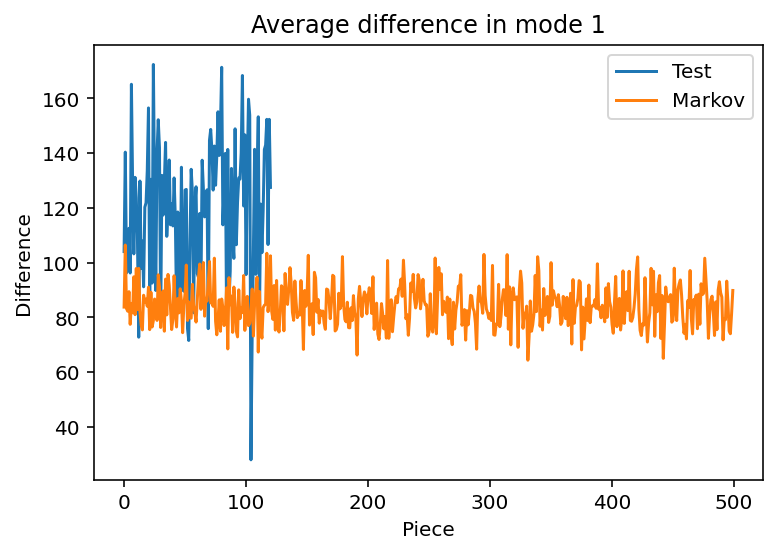

In [56]:
plt.plot(range(len(distance_average_test_1)),distance_average_test_1,label="Test")
#plt.plot(range(len(distance_average_random_1)),distance_average_random_1,label="Random")
plt.plot(range(len(distance_average_markov_1)),distance_average_markov_1,label="Markov")
plt.xlabel('Piece')
plt.ylabel('Difference')
plt.title("Average difference in mode 1")
plt.legend()

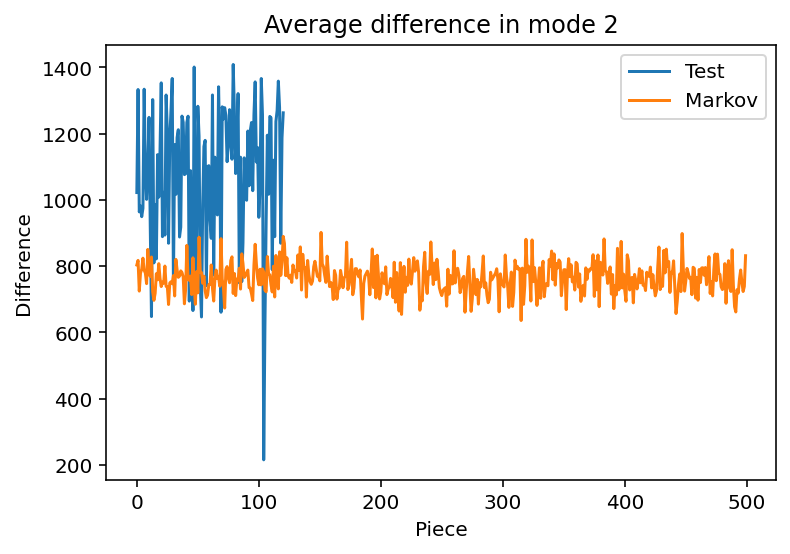

In [63]:
plt.plot(range(len(distance_average_test_2)),distance_average_test_2,label="Test")
#plt.plot(range(len(distance_average_random_2)),distance_average_random_2,label="Random")
plt.plot(range(len(distance_average_markov_2)),distance_average_markov_2,label="Markov")
plt.xlabel('Piece')
plt.ylabel('Difference')
plt.title("Average difference in mode 2")
plt.legend()

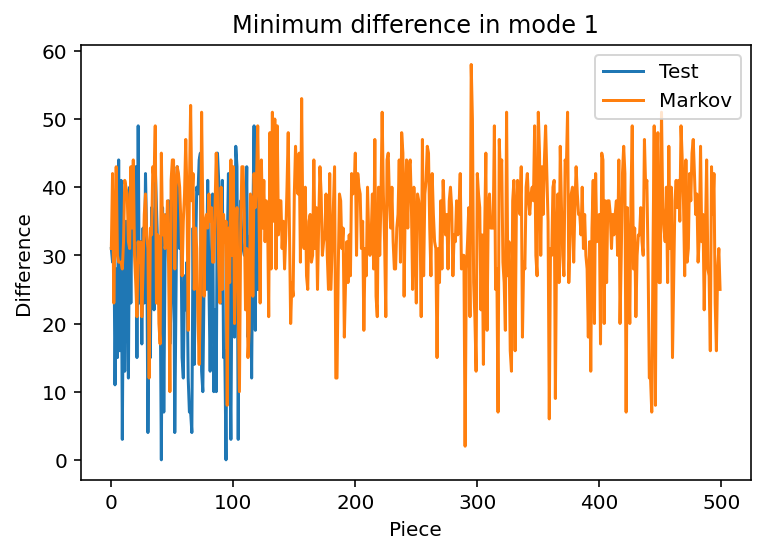

In [64]:
plt.plot(range(len(distance_minimum_test_1)),distance_minimum_test_1,label="Test")
#plt.plot(range(len(distance_minimum_random_1)),distance_minimum_random_1,label="Random")
plt.plot(range(len(distance_minimum_markov_1)),distance_minimum_markov_1,label="Markov")
plt.xlabel('Piece')
plt.ylabel('Difference')
plt.title("Minimum difference in mode 1")
plt.legend()

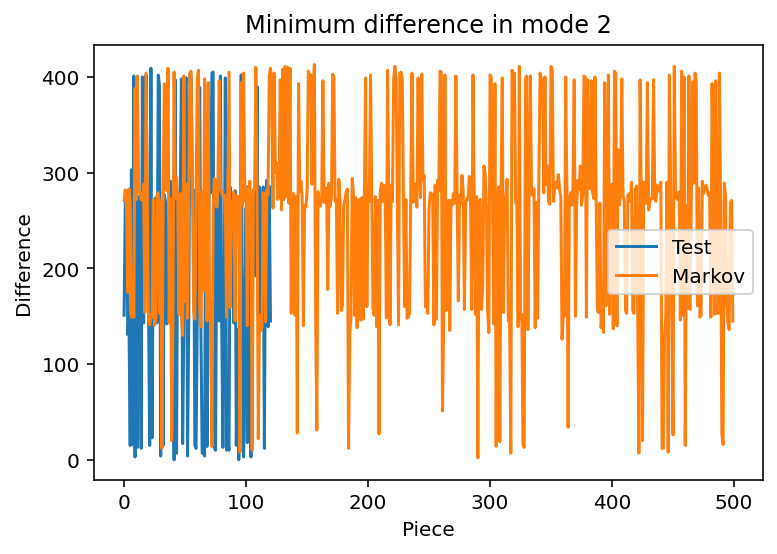

In [65]:
plt.plot(range(len(distance_minimum_test_2)),distance_minimum_test_2,label="Test")
#plt.plot(range(len(distance_minimum_random_2)),distance_minimum_random_2,label="Random")
plt.plot(range(len(distance_minimum_markov_2)),distance_minimum_markov_2,label="Markov")
plt.xlabel('Piece')
plt.ylabel('Difference')
plt.title("Minimum difference in mode 2")
plt.legend()